In [1]:
# from Sakai_mat import Sakai_mat_exp_parameter
# from Sakai_mat import Sakai_mat_exp_Short_FISTA
# from Sakai_mat import Sakai_mat_exp_Long_FISTA
# from Sakai_mat import lattice
from Sakai_mat import Sakai_mat_exp_parameter
from Sakai_mat import Sakai_mat_exp_Short_FISTA
from Sakai_mat import Sakai_mat_exp_Long_FISTA
from Sakai_mat import lattice
import time
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.sparse as spsp
import matplotlib.pyplot as plt
import csv
import os
import cProfile
import pstats

from scipy.spatial import distance
from scipy.optimize import linprog
from scipy.optimize import minimize
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

# 更新したモジュールの再reloadをしてくれる
# import importlib
# importlib.reload(Sakai_mat_exp_parameter)
# importlib.reload(Sakai_mat_exp_Short_FISTA)
# importlib.reload(Sakai_mat_exp_Long_FISTA)

In [2]:
E = 5
Col = 10
K = Col * Col
M = 1.0
N = 1.0
Scaling = 10.0 / Col
alter_T_num = 0.5

city_network = lattice.make_lattice(Col)

# 通勤費用パラメータ
t = 0.1
# 距離抵抗パラメータ
tau = 0.5

# 総土地供給量
# S_total = K
# S_bar = S_total / K
S_total = 100
S_bar = S_total / K

Coordinate_Data = \
np.array([(city_network['node_dic'][str(i)]['x_pos']*Scaling,
           city_network['node_dic'][str(i)]['y_pos']*Scaling) for i in range(K)])
distance_matrix = distance.squareform(distance.pdist(Coordinate_Data))

theta_firm = 1.0
theta_house = 1.0
alpha_1 = 0.4
alpha_2 = 0.4
beta_1 = 0.4
beta_2 = 0.4
L = 0.2
eta = 1.2
p_proj = 1e-3
RW_ini = 1.0
R_ini_list = 1.0 * np.ones(K, dtype=np.float64)
W_ini_list = 1.0 * np.ones(K, dtype=np.float64)
RW_ini_list = 1.0 * np.ones(2 * K, dtype=np.float64)
RW_proj = 1e-3

err_short = 1e-5
err_long = 1e-3
obj_corr = 1.0

m_per = M / K
m0 = np.array([m_per] * K)
n0 = np.full((K, K), N / (K * K))

method = "FISTA"
dic = "Scaling=30"

#パラメータ設定

prm = Sakai_mat_exp_parameter.Parameter(
            Col, distance_matrix, t, tau, Scaling, S_total, S_bar,
            theta_firm, theta_house, E, RW_proj, alter_T_num,
            alpha_1, alpha_2, beta_1, beta_2, M, N)

algprm = Sakai_mat_exp_parameter.Algo_Parameter(L, eta, p_proj)
short = Sakai_mat_exp_Short_FISTA.Short(prm, algprm)
long = Sakai_mat_exp_Long_FISTA.Long(prm, algprm, short)

In [3]:
prm.T

array([[0.05      , 0.1       , 0.2       , ..., 1.14017543, 1.20415946,
        1.27279221],
       [0.1       , 0.05      , 0.1       , ..., 1.08166538, 1.14017543,
        1.20415946],
       [0.2       , 0.1       , 0.05      , ..., 1.02956301, 1.08166538,
        1.14017543],
       ...,
       [1.14017543, 1.08166538, 1.02956301, ..., 0.05      , 0.1       ,
        0.2       ],
       [1.20415946, 1.14017543, 1.08166538, ..., 0.1       , 0.05      ,
        0.1       ],
       [1.27279221, 1.20415946, 1.14017543, ..., 0.2       , 0.1       ,
        0.05      ]])

In [4]:
%%time
m, n, RW, long_iteration, obj_list, obj_rel_list = long.solve(m0, n0, RW_ini, err_short, err_long, obj_corr, long_itr = 3000)

long_max_value: 0
long_max_value: 70
Lyapunov: -3.232805929620497e-05
CPU times: total: 38.9 s
Wall time: 7.8 s


In [3]:
mn0 = long.bond(m0, n0)

In [4]:
long.Z_LP(mn0, RW_ini_list)

Z_SD: 950.0698575302425
(1 / 2) * m@self.prm.D@m: 30.671003900074687
(1 / self.prm.theta_firm) *  (m @ np.log(m / self.prm.M)): -307.0113457325394
(1 / self.prm.theta_house) * np.sum(n * np.log(n / self.prm.N)): -614.0226914650788


-1901.7748986279353

In [20]:
%%time
R, W, iteration, obj_rel_list = short.short_solve(RW_ini, m0, n0, err_short, short_itr=100000, rel=0)

CPU times: total: 1.25 s
Wall time: 243 ms


In [15]:
max(iteration)

494

In [9]:
R

array([0.03127205, 0.03128549, 0.03128602, 0.03128549, 0.03127205,
       0.03128549, 0.03130088, 0.03130157, 0.03130088, 0.03128549,
       0.03128602, 0.03130157, 0.03130229, 0.03130157, 0.03128602,
       0.03128549, 0.03130088, 0.03130157, 0.03130088, 0.03128549,
       0.03127205, 0.03128549, 0.03128602, 0.03128549, 0.03127205])

In [7]:
max(iteration)

241

In [8]:
short.pi(R_ini_list, W_ini_list, m0)

array([1.38418816, 1.50363028, 1.54468214, 1.50363028, 1.38418816,
       1.50363028, 1.64301508, 1.69078289, 1.64301508, 1.50363028,
       1.54468214, 1.69078289, 1.74090979, 1.69078289, 1.54468214,
       1.50363028, 1.64301508, 1.69078289, 1.64301508, 1.50363028,
       1.38418816, 1.50363028, 1.54468214, 1.50363028, 1.38418816])

In [9]:
short.pi_noex(R_ini_list, W_ini_list, m0)

array([0.00512, 0.00512, 0.00512, 0.00512, 0.00512, 0.00512, 0.00512,
       0.00512, 0.00512, 0.00512, 0.00512, 0.00512, 0.00512, 0.00512,
       0.00512, 0.00512, 0.00512, 0.00512, 0.00512, 0.00512, 0.00512,
       0.00512, 0.00512, 0.00512, 0.00512])

In [ ]:
short.v(R_ini_list, W_ini_list)

In [13]:
short.Z_SD(RW_ini_list, m0, n0)

912.5133732018587

In [3]:
short.short_dual_df(RW_ini_list, m0, n0)

array([35.99893209, 35.99893056, 35.9989305 , 35.99893056, 35.99893209,
       35.99893056, 35.9989288 , 35.99892873, 35.9989288 , 35.99893056,
       35.9989305 , 35.99892873, 35.99892864, 35.99892873, 35.9989305 ,
       35.99893056, 35.9989288 , 35.99892873, 35.9989288 , 35.99893056,
       35.99893209, 35.99893056, 35.9989305 , 35.99893056, 35.99893209,
        0.49893209,  0.49893056,  0.4989305 ,  0.49893056,  0.49893209,
        0.49893056,  0.4989288 ,  0.49892873,  0.4989288 ,  0.49893056,
        0.4989305 ,  0.49892873,  0.49892864,  0.49892873,  0.4989305 ,
        0.49893056,  0.4989288 ,  0.49892873,  0.4989288 ,  0.49893056,
        0.49893209,  0.49893056,  0.4989305 ,  0.49893056,  0.49893209])

In [3]:
%%time
m, n, RW, long_iteration, obj_list, obj_rel_list = long.solve(m0, n0, RW_ini, err_short, err_long, obj_corr, long_itr = 300)

long_max_value: 0
long_max_value: 87
Lyapunov: -0.00521177332757361
CPU times: total: 15min 24s
Wall time: 57.8 s


In [4]:
R, W, iteration, obj_rel_list = short.short_solve(RW_ini, m, n, err_short, short_itr=100000, rel=0)

S_H, L_H, S_F, L_F = short.demand_sparse(R, W)

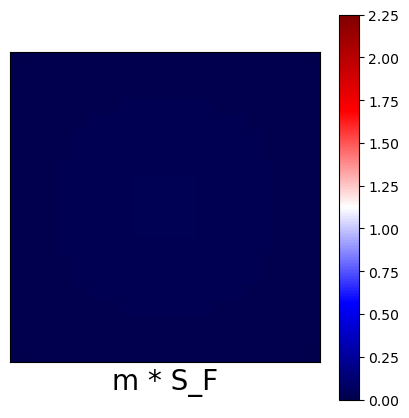

In [5]:
vmin = 0
vmax = S_bar

mat = np.reshape(m * S_F, (Col, Col))

plt.figure(figsize=(5,5))
plt.imshow(mat, interpolation='nearest', vmin = vmin, vmax = vmax, cmap='seismic')

plt.colorbar()

plt.xlabel('m * S_F', fontsize=20)

plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

plt.show()

# vmin = 0
# vmax = None

# mat = np.reshape(m_before, (self.prm.Col, self.prm.Col))

# plt.figure(figsize=(5,5))
# plt.imshow(mat, interpolation='nearest', vmin = vmin, vmax = vmax, cmap='seismic')

# plt.colorbar()

# plt.xlabel('m', fontsize=20)

# plt.gca().invert_yaxis()
# plt.xticks([])
# plt.yticks([])

# plt.show()

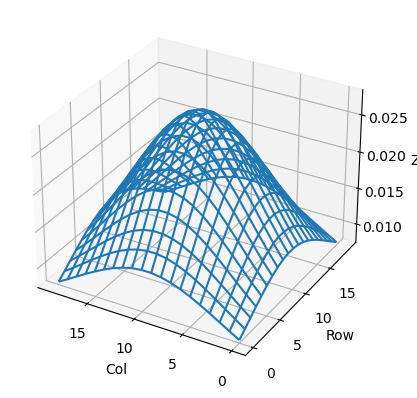

In [6]:
# 3次元行列の生成
matrix = np.reshape(m * S_F, (Col, Col))

# 行列の座標を作成
x, y = np.meshgrid(range(Col), range(Col))

# 3Dグラフの作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(x, y, matrix, cmap='viridis')

# グラフの軸ラベル設定
ax.set_xlabel('Col')
ax.set_ylabel('Row')
ax.set_zlabel('Z')

plt.gca().invert_xaxis()

# グラフ表示
plt.show()

In [4]:
np.maximum([1,1], [3,-1])

array([3, 1])

In [5]:
R = np.random.rand(prm.K)
W = np.random.rand(prm.K)

In [6]:
%%time
for i in range(10**4):
    __ = long.short.demand_sparse(R, W)

CPU times: total: 562 ms
Wall time: 571 ms
